In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime 
from sklearn import preprocessing

import torch
import torch.nn as nn
from torch.optim import Adam
import torch.utils.data as data_utils 

import cryptocompare

In [2]:
class NeuralNet(nn.Module):
    def __init__(self, 
                 activation_function = nn.ReLU,
                 optimizer = Adam,
                 dropout = 0.2
                ):
        super(NeuralNet, self).__init__()
        input_dim = 5
        hidden_dim = 100
        output_dim = 1
        self.lstm = nn.LSTM(input_dim, hidden_dim)
        self.layers =[nn.Dropout(p = dropout)]
        self.layers.append(nn.Linear(hidden_dim, output_dim))
        self.layers = nn.Sequential(*self.layers)


    def forward(self, x):
        out, _ = self.lstm(x.view(len(x), 1 , -1))
        out = self.layers(out.view(len(x), -1))
        return out

In [3]:
data = cryptocompare.get_historical_price_day('BTC', 'EUR', limit=2000, exchange='CCCAGG', toTs=datetime.now())
df = pd.DataFrame.from_dict(data)
df = df.set_index('time')
df.index = pd.to_datetime(df.index, unit='s')

df.head()


,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol
time,,,,,,,,
2015-11-10,354.07,304.66,352.13,18512.46,6167808.23,315.33,direct,
2015-11-11,319.04,277.11,315.33,25162.20,7414887.02,286.21,direct,
2015-11-12,322.89,285.20,286.21,16081.06,4951233.18,309.10,direct,
2015-11-13,318.11,301.81,309.10,6918.45,2152774.19,312.61,direct,
2015-11-14,315.94,305.17,312.61,4047.36,1254658.50,309.63,direct,


In [4]:
df = df.iloc[:, :6]
df.head()

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2015-11-10,354.07,304.66,352.13,18512.46,6167808.23,315.33
2015-11-11,319.04,277.11,315.33,25162.20,7414887.02,286.21
2015-11-12,322.89,285.20,286.21,16081.06,4951233.18,309.10
2015-11-13,318.11,301.81,309.10,6918.45,2152774.19,312.61
2015-11-14,315.94,305.17,312.61,4047.36,1254658.50,309.63


In [5]:
def split_data(data, train_prop=0.8):
    train_data = df.iloc[:int(train_prop * len(data))]
    test_data = df.iloc[int(train_prop * len(data)):]
    return train_data, test_data

train_data, test_data = split_data(df, train_prop=0.8)


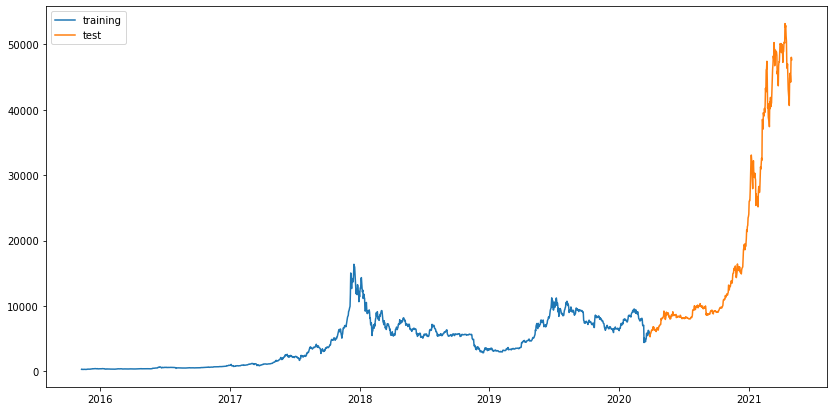

In [30]:

def plot_curves(to_plot, labels, title='', x_label='', y_label=''):
    fig, ax = plt.subplots(1, figsize=(14, 7))
    for i in range(len(to_plot)):
        ax.plot(to_plot[i], label=labels[i])
    
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)
    ax.legend()
plot_curves([train_data['close'], test_data['close']], ['training', 'test'], title='')

In [7]:
def normalize_data(dataframe):
    x = dataframe.values
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    normalized_df = pd.DataFrame(x_scaled, columns = dataframe.columns)
    return normalized_df

def denormalize_data(real_df, normalized_df):
    x = real_df.values
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    new_x = x_scaled* (min_max_scaler.data_max_-min_max_scaler.data_min_) + min_max_scaler.data_min_
    return pd.DataFrame(new_x, columns = df.columns)
    

    

In [8]:
train_data.head()

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2015-11-10,354.07,304.66,352.13,18512.46,6167808.23,315.33
2015-11-11,319.04,277.11,315.33,25162.20,7414887.02,286.21
2015-11-12,322.89,285.20,286.21,16081.06,4951233.18,309.10
2015-11-13,318.11,301.81,309.10,6918.45,2152774.19,312.61
2015-11-14,315.94,305.17,312.61,4047.36,1254658.50,309.63


In [9]:
train_normalized = normalize_data(train_data)
train_normalized.head()

,high,low,open,volumefrom,volumeto,close
0,0.003004,0.001779,0.004097,0.161394,0.004066,0.001810
1,0.000863,0.000000,0.001810,0.226121,0.005061,0.000000
2,0.001099,0.000522,0.000000,0.137728,0.003095,0.001423
3,0.000807,0.001595,0.001423,0.048541,0.000863,0.001641
4,0.000674,0.001812,0.001641,0.020595,0.000146,0.001456


In [10]:
denormalize_data(train_data, train_normalized).head()

,high,low,open,volumefrom,volumeto,close
0,354.07,304.66,352.13,18512.46,6167808.23,315.33
1,319.04,277.11,315.33,25162.20,7414887.02,286.21
2,322.89,285.20,286.21,16081.06,4951233.18,309.10
3,318.11,301.81,309.10,6918.45,2152774.19,312.61
4,315.94,305.17,312.61,4047.36,1254658.50,309.63


In [11]:
train_target_tensor = torch.tensor(train_normalized['close'].values.astype(np.float64))
train_data_tensor = torch.tensor(train_normalized.drop('close', axis = 1).values) 
train_tensor = data_utils.TensorDataset(train_data_tensor, train_target_tensor) 
train_loader = data_utils.DataLoader(dataset = train_tensor, batch_size = 32, shuffle = True)


In [12]:
from tqdm import tqdm


model = NeuralNet()

EPOCHS = 1000

target = pd.DataFrame(data = train_normalized['close'])


criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=0.0001)

losses = []
for epoch in range(EPOCHS):
    epoch_loss = 0
    for bidx, batch in tqdm(enumerate(train_loader)):
        X, Y = batch
        model.zero_grad()
        loss = 0
        for i in range(len(X)):
            x, y = X[i], Y[i]
            x = x.view(-1, len(x))
            
            #Forward Pass
            y_hat = model(x.float())
            
            #Loss
            loss += criterion(y.float(), y_hat.float())
        
        #Backward pass
        loss.backward()
        
        #Parameters optimization
        optimizer.step()
        
        epoch_loss += float(loss)
        
    losses.append(epoch_loss)
    print("Epoch ", epoch, ": ", epoch_loss)
        
        
  

0it [00:00, ?it/s]/home/wissam/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
50it [00:01, 48.20it/s]
5it [00:00, 45.93it/s]

Epoch  0 :  116.55724382400513


50it [00:01, 48.61it/s]
5it [00:00, 47.06it/s]

Epoch  1 :  98.99337530136108


50it [00:01, 46.78it/s]
5it [00:00, 41.36it/s]

Epoch  2 :  83.34015256166458


50it [00:00, 50.95it/s]
6it [00:00, 54.25it/s]

Epoch  3 :  70.70612370967865


50it [00:00, 54.64it/s]
6it [00:00, 52.73it/s]

Epoch  4 :  60.068966925144196


50it [00:00, 50.71it/s]
5it [00:00, 49.59it/s]

Epoch  5 :  52.70289784669876


50it [00:01, 48.29it/s]
6it [00:00, 53.96it/s]

Epoch  6 :  47.25172108411789


50it [00:00, 54.84it/s]
6it [00:00, 54.03it/s]

Epoch  7 :  42.804415464401245


50it [00:01, 44.73it/s]
4it [00:00, 33.87it/s]

Epoch  8 :  39.07967168092728


50it [00:01, 33.27it/s]
3it [00:00, 29.55it/s]

Epoch  9 :  35.72084632515907


50it [00:01, 32.98it/s]
3it [00:00, 20.83it/s]

Epoch  10 :  32.527433812618256


50it [00:01, 31.77it/s]
4it [00:00, 30.99it/s]

Epoch  11 :  28.89902099967003


50it [00:01, 32.55it/s]
4it [00:00, 31.39it/s]

Epoch  12 :  25.455171138048172


50it [00:01, 33.36it/s]
3it [00:00, 29.85it/s]

Epoch  13 :  22.200459420681


50it [00:01, 33.75it/s]
4it [00:00, 32.56it/s]

Epoch  14 :  19.16326132416725


50it [00:01, 33.99it/s]
4it [00:00, 33.16it/s]

Epoch  15 :  15.703982159495354


50it [00:01, 33.86it/s]
4it [00:00, 31.34it/s]

Epoch  16 :  13.276692375540733


50it [00:01, 34.02it/s]
4it [00:00, 33.65it/s]

Epoch  17 :  10.533912315964699


50it [00:01, 33.92it/s]
4it [00:00, 31.99it/s]

Epoch  18 :  8.384245127439499


50it [00:01, 33.96it/s]
4it [00:00, 32.96it/s]

Epoch  19 :  6.5277282148599625


50it [00:01, 34.23it/s]
4it [00:00, 31.11it/s]

Epoch  20 :  4.852267771959305


50it [00:01, 34.07it/s]
4it [00:00, 31.84it/s]

Epoch  21 :  3.761575438082218


50it [00:01, 33.76it/s]
4it [00:00, 33.94it/s]

Epoch  22 :  2.9513672813773155


50it [00:01, 34.03it/s]
4it [00:00, 33.56it/s]

Epoch  23 :  2.216344116255641


50it [00:01, 34.85it/s]
4it [00:00, 35.03it/s]

Epoch  24 :  1.9523598831146955


50it [00:01, 34.61it/s]
4it [00:00, 35.23it/s]

Epoch  25 :  1.6450343765318394


50it [00:01, 34.09it/s]
4it [00:00, 34.86it/s]

Epoch  26 :  1.304260166361928


50it [00:01, 34.48it/s]
4it [00:00, 33.65it/s]

Epoch  27 :  1.385765423066914


50it [00:01, 35.15it/s]
4it [00:00, 34.89it/s]

Epoch  28 :  1.206619260367006


50it [00:01, 35.32it/s]
4it [00:00, 33.05it/s]

Epoch  29 :  1.141484448686242


50it [00:01, 35.10it/s]
4it [00:00, 33.27it/s]

Epoch  30 :  1.0883306143805385


50it [00:01, 35.44it/s]
4it [00:00, 35.13it/s]

Epoch  31 :  1.1269823592156172


50it [00:01, 35.88it/s]
4it [00:00, 34.13it/s]

Epoch  32 :  1.0674629560671747


50it [00:01, 35.27it/s]
4it [00:00, 36.11it/s]

Epoch  33 :  1.1882734699174762


50it [00:01, 34.48it/s]
4it [00:00, 35.04it/s]

Epoch  34 :  1.115150754339993


50it [00:01, 35.27it/s]
4it [00:00, 35.21it/s]

Epoch  35 :  1.1815928313881159


50it [00:01, 35.89it/s]
4it [00:00, 36.24it/s]

Epoch  36 :  0.967708530370146


50it [00:01, 35.69it/s]
4it [00:00, 33.40it/s]

Epoch  37 :  1.0801114081405103


50it [00:01, 34.99it/s]
4it [00:00, 33.38it/s]

Epoch  38 :  1.0771297998726368


50it [00:01, 35.09it/s]
4it [00:00, 34.78it/s]

Epoch  39 :  0.9690733049064875


50it [00:01, 34.85it/s]
4it [00:00, 33.28it/s]

Epoch  40 :  0.9376229089684784


50it [00:01, 35.47it/s]
4it [00:00, 36.59it/s]

Epoch  41 :  1.0088384267874062


50it [00:01, 35.72it/s]
4it [00:00, 33.04it/s]

Epoch  42 :  0.9508304377086461


50it [00:01, 35.49it/s]
4it [00:00, 36.33it/s]

Epoch  43 :  0.9450430790893734


50it [00:01, 36.15it/s]
4it [00:00, 36.17it/s]

Epoch  44 :  0.9974841722287238


50it [00:01, 35.64it/s]
4it [00:00, 32.07it/s]

Epoch  45 :  0.9547801157459617


50it [00:01, 35.27it/s]
4it [00:00, 34.76it/s]

Epoch  46 :  0.9159941608086228


50it [00:01, 35.63it/s]
4it [00:00, 35.84it/s]

Epoch  47 :  0.8973320783115923


50it [00:01, 35.75it/s]
4it [00:00, 35.49it/s]

Epoch  48 :  0.8493832224048674


50it [00:01, 35.64it/s]
4it [00:00, 35.68it/s]

Epoch  49 :  0.8985375561751425


50it [00:01, 36.18it/s]
4it [00:00, 33.12it/s]

Epoch  50 :  0.8462092210538685


50it [00:01, 34.69it/s]
4it [00:00, 34.22it/s]

Epoch  51 :  0.8993953154422343


50it [00:01, 35.29it/s]
4it [00:00, 35.54it/s]

Epoch  52 :  0.9914173628203571


50it [00:01, 35.01it/s]
4it [00:00, 32.91it/s]

Epoch  53 :  0.8565026521682739


50it [00:01, 34.98it/s]
4it [00:00, 34.51it/s]

Epoch  54 :  0.8425930235534906


50it [00:01, 34.82it/s]
4it [00:00, 34.59it/s]

Epoch  55 :  0.8644380420446396


50it [00:01, 34.89it/s]
4it [00:00, 34.52it/s]

Epoch  56 :  0.8934409990906715


50it [00:01, 34.77it/s]
4it [00:00, 34.80it/s]

Epoch  57 :  0.9612016770988703


50it [00:01, 35.13it/s]
4it [00:00, 34.62it/s]

Epoch  58 :  0.8477614815346897


50it [00:01, 35.04it/s]
4it [00:00, 33.27it/s]

Epoch  59 :  0.8754904894158244


50it [00:01, 34.88it/s]
4it [00:00, 34.40it/s]

Epoch  60 :  0.7632242287509143


50it [00:01, 35.18it/s]
3it [00:00, 29.97it/s]

Epoch  61 :  0.905612581409514


50it [00:01, 34.40it/s]
4it [00:00, 34.87it/s]

Epoch  62 :  0.8139513968490064


50it [00:01, 34.92it/s]
4it [00:00, 34.43it/s]

Epoch  63 :  0.7647363618016243


50it [00:01, 34.84it/s]
4it [00:00, 34.61it/s]

Epoch  64 :  0.816836575511843


50it [00:01, 34.93it/s]
4it [00:00, 33.52it/s]

Epoch  65 :  0.8318434660322964


50it [00:01, 34.88it/s]
4it [00:00, 33.74it/s]

Epoch  66 :  0.7262375191785395


50it [00:01, 34.80it/s]
4it [00:00, 33.88it/s]

Epoch  67 :  0.6793652868364006


50it [00:01, 34.80it/s]
4it [00:00, 31.66it/s]

Epoch  68 :  0.7302526896819472


50it [00:01, 34.54it/s]
4it [00:00, 33.58it/s]

Epoch  69 :  0.7880149707198143


50it [00:01, 34.44it/s]
4it [00:00, 34.46it/s]

Epoch  70 :  0.7872453504242003


50it [00:01, 35.03it/s]
4it [00:00, 34.64it/s]

Epoch  71 :  0.7792687159962952


50it [00:01, 30.31it/s]
4it [00:00, 31.58it/s]

Epoch  72 :  0.7392458613030612


50it [00:01, 34.52it/s]
4it [00:00, 34.18it/s]

Epoch  73 :  0.7881870646961033


50it [00:01, 34.65it/s]
4it [00:00, 33.05it/s]

Epoch  74 :  0.7261812277138233


50it [00:01, 34.77it/s]
4it [00:00, 34.15it/s]

Epoch  75 :  0.7496142368763685


50it [00:01, 35.03it/s]
4it [00:00, 34.98it/s]

Epoch  76 :  0.8338536322116852


50it [00:01, 34.50it/s]
4it [00:00, 34.43it/s]

Epoch  77 :  0.6969649423845112


50it [00:01, 35.01it/s]
4it [00:00, 32.37it/s]

Epoch  78 :  0.7162718237377703


50it [00:01, 35.15it/s]
4it [00:00, 33.59it/s]

Epoch  79 :  0.7584981061518192


50it [00:01, 35.21it/s]
4it [00:00, 35.07it/s]

Epoch  80 :  0.76442855829373


50it [00:01, 34.94it/s]
4it [00:00, 35.68it/s]

Epoch  81 :  0.6973615288734436


50it [00:01, 34.61it/s]
4it [00:00, 34.60it/s]

Epoch  82 :  0.7019758503884077


50it [00:01, 35.29it/s]
4it [00:00, 33.91it/s]

Epoch  83 :  0.7226489470340312


50it [00:01, 35.70it/s]
4it [00:00, 34.11it/s]

Epoch  84 :  0.7687755930237472


50it [00:01, 35.82it/s]
4it [00:00, 35.11it/s]

Epoch  85 :  0.7334726429544389


50it [00:01, 36.07it/s]
4it [00:00, 35.91it/s]

Epoch  86 :  0.703021103516221


50it [00:01, 35.54it/s]
4it [00:00, 34.41it/s]

Epoch  87 :  0.7194295478984714


50it [00:01, 33.80it/s]
4it [00:00, 34.06it/s]

Epoch  88 :  0.7186889159493148


50it [00:01, 36.09it/s]
4it [00:00, 36.88it/s]

Epoch  89 :  0.7051652227528393


50it [00:01, 36.43it/s]
4it [00:00, 34.23it/s]

Epoch  90 :  0.6777636655606329


50it [00:01, 36.18it/s]
4it [00:00, 34.72it/s]

Epoch  91 :  0.6914926464669406


50it [00:01, 36.14it/s]
4it [00:00, 32.88it/s]

Epoch  92 :  0.6392647349275649


50it [00:01, 35.83it/s]
4it [00:00, 33.71it/s]

Epoch  93 :  0.7084800400771201


50it [00:01, 35.95it/s]
4it [00:00, 36.00it/s]

Epoch  94 :  0.6667458126321435


50it [00:01, 36.33it/s]
4it [00:00, 35.57it/s]

Epoch  95 :  0.6451657847501338


50it [00:01, 36.42it/s]
4it [00:00, 34.23it/s]

Epoch  96 :  0.6072227095719427


50it [00:01, 35.81it/s]
4it [00:00, 35.80it/s]

Epoch  97 :  0.6503953684587032


50it [00:01, 35.89it/s]
4it [00:00, 37.06it/s]

Epoch  98 :  0.6602194453589618


50it [00:01, 36.13it/s]
4it [00:00, 34.52it/s]

Epoch  99 :  0.7657012916170061


50it [00:01, 31.41it/s]
3it [00:00, 24.06it/s]

Epoch  100 :  0.6875045946799219


50it [00:01, 26.49it/s]
4it [00:00, 31.32it/s]

Epoch  101 :  0.6217915778979659


50it [00:01, 27.52it/s]
3it [00:00, 23.90it/s]

Epoch  102 :  0.6577129536308348


50it [00:01, 31.27it/s]
3it [00:00, 24.64it/s]

Epoch  103 :  0.6530209640040994


50it [00:01, 27.44it/s]
3it [00:00, 25.14it/s]

Epoch  104 :  0.6777090071700513


50it [00:01, 26.03it/s]
4it [00:00, 30.69it/s]

Epoch  105 :  0.6059460300020874


50it [00:01, 31.26it/s]
4it [00:00, 33.56it/s]

Epoch  106 :  0.6399593837559223


50it [00:01, 32.83it/s]
4it [00:00, 34.75it/s]

Epoch  107 :  0.5717175570316613


50it [00:01, 35.20it/s]
4it [00:00, 33.30it/s]

Epoch  108 :  0.629707875661552


50it [00:01, 34.87it/s]
4it [00:00, 35.42it/s]

Epoch  109 :  0.6784077589400113


50it [00:01, 35.10it/s]
4it [00:00, 32.06it/s]

Epoch  110 :  0.6100125364027917


50it [00:01, 35.13it/s]
4it [00:00, 34.97it/s]

Epoch  111 :  0.6327049247920513


50it [00:01, 35.19it/s]
4it [00:00, 34.68it/s]

Epoch  112 :  0.6075708256103098


50it [00:01, 31.16it/s]
3it [00:00, 28.21it/s]

Epoch  113 :  0.6421427512541413


50it [00:01, 32.75it/s]
4it [00:00, 34.91it/s]

Epoch  114 :  0.6059949367772788


50it [00:01, 33.59it/s]
3it [00:00, 29.62it/s]

Epoch  115 :  0.5649401838891208


50it [00:01, 31.43it/s]
4it [00:00, 29.75it/s]

Epoch  116 :  0.6343106883578002


50it [00:01, 28.96it/s]
4it [00:00, 31.28it/s]

Epoch  117 :  0.6505145621486008


50it [00:01, 31.41it/s]
3it [00:00, 28.26it/s]

Epoch  118 :  0.594062683172524


18it [00:00, 30.51it/s]


KeyboardInterrupt: 

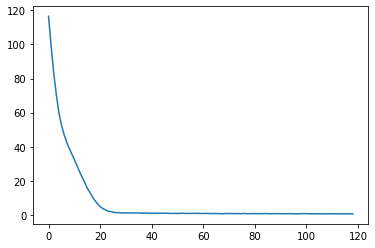

In [13]:
plt.plot(losses)

In [14]:
test_normalized = normalize_data(test_data)

test_target = torch.tensor(test_normalized['close'].values.astype(np.float64))
test = torch.tensor(test_normalized.drop('close', axis = 1).values) 
test_tensor = data_utils.TensorDataset(test, test_target) 
test_loader = data_utils.DataLoader(dataset = test_tensor, batch_size = 32, shuffle = False)


In [15]:
x_labels = list(test_data.index)

13it [00:00, 70.49it/s]


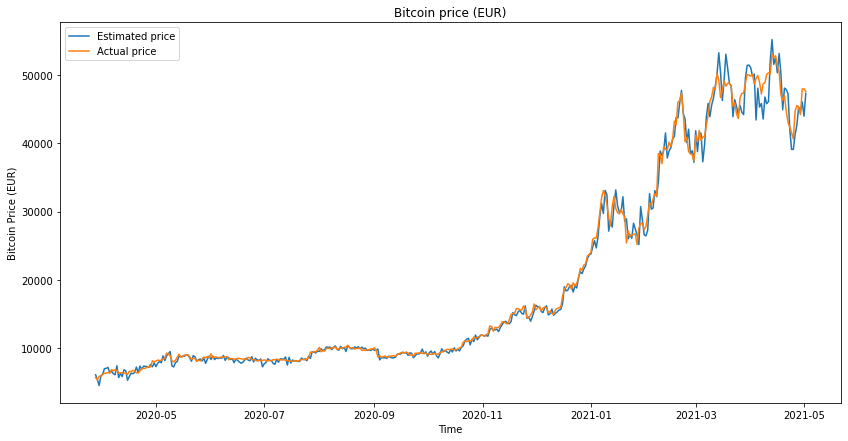

In [37]:
y_list = []
y_hat_list = []
for bidx, batch in tqdm(enumerate(test_loader)):
        X, Y = batch
        for i in range(len(X)):
            x, y = X[i], Y[i]
            x = x.view(-1, len(x))
            y_hat = model(x.float())
            y_list.append(float(y))
            y_hat_list.append(float(y_hat))

#Denormalize the data
min_max_scaler = preprocessing.MinMaxScaler()
min_max_scaler.fit_transform(test_data.values)
vmin = min_max_scaler.data_min_[-1]
vmax = min_max_scaler.data_max_[-1]


y_list = [y_list[i]* (vmax - vmin) + vmin for i in range(len(y_list))]
y_hat_list = [y_hat_list[i]* (vmax - vmin) + vmin for i in range(len(y_hat_list))]

y_df = pd.DataFrame(y_list)
y_df.index = test_data.index

y_hat_df = pd.DataFrame(y_hat_list)
y_hat_df.index = test_data.index


plot_curves([y_hat_df, y_df], ['Estimated price', 'Actual price'], 
            title='Bitcoin price (EUR)', x_label='Time', y_label='Bitcoin Price (EUR)')


In [38]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth